In [1]:
import pandas as pd
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp
import numpy as np
from hyperopt import Trials, tpe, fmin


In [2]:
ma = pd.read_csv("../16 Mycoplosma/ma.csv")
map = pd.read_csv("../16 Mycoplosma/map.csv")
marth = pd.read_csv("../16 Mycoplosma/marth.csv")
mcap = pd.read_csv("../16 Mycoplosma/mcap.csv")
mcon = pd.read_csv("../16 Mycoplosma/mcon.csv")
mcro = pd.read_csv("../16 Mycoplosma/mcro.csv")
mgal = pd.read_csv("../16 Mycoplosma/mgal.csv")
mhom = pd.read_csv("../16 Mycoplosma/mhom.csv")
mhyoJ = pd.read_csv("../16 Mycoplosma/mhyoJ.csv")
mhyo232 = pd.read_csv("../16 Mycoplosma/mhyo232.csv")
mhyo7448 = pd.read_csv("../16 Mycoplosma/mhyo7448.csv")
mm163K = pd.read_csv("../16 Mycoplosma/mm163K.csv")
mms = pd.read_csv("../16 Mycoplosma/mms.csv")
mpHF = pd.read_csv("../16 Mycoplosma/mpHF.csv")
mpM = pd.read_csv("../16 Mycoplosma/mpM.csv")
ms53 = pd.read_csv("../16 Mycoplosma/ms53.csv")

In [3]:
def generate_train_test_dataset(index):
    dataset_names = [ma, map, marth, mcap, mcon, mcro, mgal, mhom, mhyoJ, mhyo232, mhyo7448, mm163K, mms, mpHF, mpM, ms53]
    merged_train = dataset_names[:index]+dataset_names[index+1:]
    train_data = pd.concat(merged_train)
    test_data = dataset_names[index]
    return train_data,test_data

In [4]:
train_data , test_data = generate_train_test_dataset(0)

In [5]:
def handle_dataset(dataset):
    columns_to_drop = ['identity','name', 'Amino acid', 'protein_sequence', 'essentiality']
    Xs = dataset.drop(columns = columns_to_drop)
    y = dataset['essentiality']
    return Xs,y

In [6]:
Xs_train,y_train = handle_dataset(train_data)
Xs_test,y_test = handle_dataset(test_data)

In [7]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(Xs_train, y_train)

In [8]:
import warnings
warnings.filterwarnings("ignore")
trials = Trials()

In [52]:
from sklearn.svm import SVC
def svm_bca_cv(params):
    model = SVC(C = params["C"],kernel ="linear", degree = int(params["degree"]), gamma = params["gamma"])
    scorer = make_scorer(balanced_accuracy_score)
    score = -cross_val_score(model, X_resampled, y_resampled, cv=5,scoring=scorer, ).mean()
    return score

In [10]:
space = {
    'C': hp.loguniform('C', -5, 2),  # 正则化参数 C
    'kernel': hp.choice('kernel', ['linear', 'rbf']),  # 核函数选择
    'degree': hp.quniform('degree', 2, 5, 1),  # 多项式核的次数
    'gamma': hp.choice('gamma', ['auto', 'scale', hp.loguniform('gamma_val', -5, 2)])  # 核函数的系数
}

In [11]:
trials = Trials()
best=fmin(fn=svm_bca_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=50, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
         )


100%|██████████| 50/50 [29:17<00:00, 35.15s/trial, best loss: -0.8463066853669939] 


In [13]:
best

{'C': 4.447352149446517, 'degree': 5.0, 'gamma': 1, 'kernel': 0}

In [45]:
space2 = {
    'C': hp.loguniform('C', -5, 2),  # 正则化参数 C
    'kernel': hp.choice('kernel', ['linear']),  # 核函数选择
    'degree': hp.quniform('degree', 2, 15, 1),  # 多项式核的次数
    'gamma': hp.choice('gamma', ['auto', 'scale'])  # 核函数的系数
}

In [21]:
trials = Trials()
best=fmin(fn=svm_bca_cv, # function to optimize
          space=space2, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=50, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
         )

100%|██████████| 50/50 [32:47<00:00, 39.36s/trial, best loss: -0.8473819541841981] 


In [18]:
best

{'C': 2.960894486282841,
 'degree': 3.0,
 'gamma': 2,
 'gamma_val': 7.23485609161834}

In [22]:
best

{'C': 6.800148981369235, 'degree': 9.0, 'gamma': 0, 'kernel': 0}

In [23]:
model1 = SVC(C=4.447352149446517, degree=5, gamma = 1, kernel = 'linear')
model1 .fit(X_resampled,y_resampled)
tpe_test_score=balanced_accuracy_score(y_test, model1.predict(Xs_test))
print(tpe_test_score)

0.8811102923114713


In [24]:
model2 = SVC(C=6.800148981369235, degree=9, gamma = 0, kernel = 'linear')
model2 .fit(X_resampled,y_resampled)
tpe_test_score2=balanced_accuracy_score(y_test, model2.predict(Xs_test))
print(tpe_test_score2)

0.9000245639891918


In [25]:
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest, mutual_info_classif

#feature selection
#RFE
score = []
scorer = make_scorer(balanced_accuracy_score)
for i in range(26,5,-1):
	X_mutual = SelectKBest(score_func=mutual_info_classif, k=i).fit_transform(X_resampled, y_resampled)
	once = cross_val_score(model2, X_mutual, y_resampled, cv=3,scoring=scorer)
	score.append(once.mean())

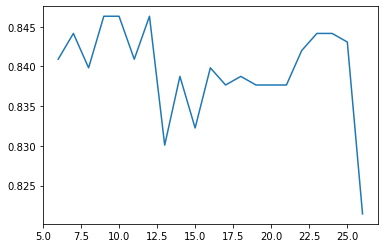

In [26]:
plt.plot(range(26,5,-1), score)
plt.show()    

In [27]:
from sklearn.feature_selection import RFECV

X_mutual = SelectKBest(score_func=mutual_info_classif, k=25).fit_transform(X_resampled, y_resampled)
rfecv = RFECV(estimator=model2,  
              min_features_to_select=5, 
              step=1,               
              cv=3,
              verbose = 1,
              n_jobs = 1
              ).fit(X_mutual,y_resampled)
X_RFECV = rfecv.transform(X_mutual)
print("RFECVresult——————————————————————————————————————————————————")
print("valid : %d" % rfecv.n_features_)
print("ranking : %s" % list(rfecv.ranking_))

Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 featur

In [28]:
all_feature_names = ["GC_Content","CAI","A","R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V","SE2","SE3","GE2","GE3"]
selected_feature_names = [all_feature_names[i] for i, rank in enumerate(rfecv.ranking_) if rank == 1]

print("Selected feature names:", selected_feature_names)

Selected feature names: ['GC_Content', 'CAI', 'A', 'R', 'N', 'Q', 'E', 'H', 'I', 'L', 'K', 'P', 'W', 'Y']


In [29]:
Wrapper_score = cross_val_score(model2,X_RFECV,y_resampled,cv=5,scoring=scorer).mean()
print(Wrapper_score)

0.857129499766246


In [31]:
model2.fit(X_resampled,y_resampled)
Xs_test_mutual = SelectKBest(mutual_info_classif, k=25).fit_transform(Xs_test,y_test)
Xs_test_rfe = rfecv.transform(Xs_test_mutual)
test_score = balanced_accuracy_score(y_test, model2.predict(Xs_test))
print(test_score)

0.9000245639891918


In [32]:
def feature_selection(Xs,y):
    Xs_result = SelectKBest(mutual_info_classif, k=25).fit_transform(Xs,y)
    Xs_result = rfecv.transform(Xs_result)
    return Xs_result

In [53]:
space = {
    'C': hp.loguniform('C', -5, 2),  # 正则化参数 C
    'degree': hp.quniform('degree', 2, 5, 1),  # 多项式核的次数
    'gamma': hp.choice('gamma', ['auto', 'scale', hp.loguniform('gamma_val', -5, 2)])  # 核函数的系数
}

In [60]:

for i in range(8,15):
    if i == 3 :
        scores.append(0.8227968346578312)
        continue
    if i ==12:
        scores.append(0.8013582987129056)
        continue
    
    train_data, test_data = generate_train_test_dataset(i)
    Xs_train,y_train = handle_dataset(train_data)
    Xs_test,y_test = handle_dataset(test_data)
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = rus.fit_resample(Xs_train, y_train)
    #X_resampled = feature_selection(X_resampled,y_resampled)
    trials = Trials()
    params=fmin(fn=svm_bca_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=20, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
    )
    model = SVC(C = params["C"],kernel ="linear", degree = int(params["degree"]), gamma = params["gamma"])
    models.append(model)
    model.fit(X_resampled,y_resampled)
   #Xs_test_fs = feature_selection(Xs_test,y_test)
    tpe_test_score=balanced_accuracy_score(y_test, model.predict(Xs_test))
    scores.append(tpe_test_score)
    print(tpe_test_score)
    if score < tpe_test_score:
        score = tpe_test_score
        best_model = model

100%|██████████| 20/20 [06:48<00:00, 20.43s/trial, best loss: -0.8572637840311141]
0.721780303030303
100%|██████████| 20/20 [06:23<00:00, 19.17s/trial, best loss: -0.8415750915750916]
0.8471663888616532
100%|██████████| 20/20 [06:59<00:00, 20.95s/trial, best loss: -0.8551704415465569]
0.8547348484848485
100%|██████████| 20/20 [06:42<00:00, 20.15s/trial, best loss: -0.8465871902758298]
0.8035190615835777
100%|██████████| 20/20 [07:17<00:00, 21.86s/trial, best loss: -0.8505263157894737]
0.8717948717948718
100%|██████████| 20/20 [03:41<00:00, 11.07s/trial, best loss: -0.8232142857142858]
0.6350662503164823


In [58]:
print(scores)

[0.9014369933677229, 0.8071743929359824, 0.6045115894039735, 0.5027968346578312, 0.8656780387450711, 0.8434568480300189, 0.8360089186176143, 0.9130041598842467]


In [62]:
print(scores)

[0.9014369933677229, 0.8071743929359824, 0.6045115894039735, 0.5027968346578312, 0.8656780387450711, 0.8434568480300189, 0.8360089186176143, 0.9130041598842467, 0.721780303030303, 0.8471663888616532, 0.8547348484848485, 0.8035190615835777, 0.8013582987129056, 0.8717948717948718, 0.6350662503164823]


In [56]:
tpe_test_score=balanced_accuracy_score(y_test, model.predict(Xs_test))
scores.append(tpe_test_score)
print(tpe_test_score)
if score < tpe_test_score:
    score = tpe_test_score
    best_model = model

0.9014369933677229


In [43]:
model = SVC(C=6.2463624366109745,
                kernel='linear',
                degree=11,
                gamma='auto')
models.append(model)
model.fit(X_resampled,y_resampled)
Xs_test_fs = feature_selection(Xs_test,y_test)
tpe_test_score=balanced_accuracy_score(y_test, model.predict(Xs_test_fs))
scores.append(tpe_test_score)
print(tpe_test_score)
if score < tpe_test_score:
    score = tpe_test_score
    best_model = model

0.5


In [96]:
scores = [0.501412429378531, 0.5011037527593819, 0.5502897350993378, 0.5127968346578312, 0.501628664495114, 0.5015243902439024, 0.5012820512820513, 0.5189003436426117, 0.5015151515151515, 0.5007598784194529, 0.5015151515151515, 0.501466275659824,0.5123582987129056, 0.5012820512820513, 0.4975609756097561]

In [63]:
from joblib import dump

dump(best_model, '../../model/SVM_model.joblib')

['../../model/SVM_model.joblib']